# Transit detection

```{admonition} Talk
:class: tip
Introduction to *nuance*
```


We saw that detrending the light curve would not be an ideal choice to automatically detect transit signals in a light curve containing correlated noise. In this notebook we will learn how to use nuance in order to detect transits lost in correlated noise.

Let's load our signal again

/Users/lgarcia/mambaforge/envs/pysnack10/lib/python3.11/site-packages/prose/console_utils.py:15: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


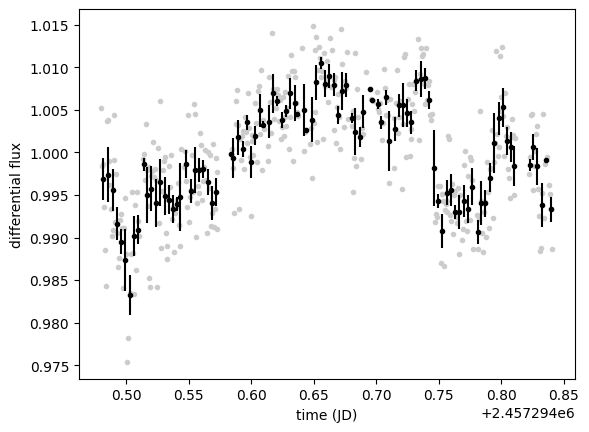

In [1]:
from prose import Fluxes
import matplotlib.pyplot as plt

# this is the second dataset
data = Fluxes.load("../data/TRAPPIST-South_20150928_UCDTS-48_I+z.flux")

ax = plt.subplot(xlabel="time (JD)", ylabel="differential flux")
data.plot()
data.bin(5 / 60 / 24, estimate_error=True).errorbar()

And redefine what we think might be a good model for the systematics

In [2]:
import numpy as np

X = np.vstack(
    [
        data.data["airmass"],
        data.data["fwhm"],
        data.data["bkg"],
        data.data["dx"],
        data.data["dy"],
    ]
)

# normalizing
X = (X - np.mean(X, axis=1)[:, None]) / np.std(X, axis=1)[:, None]

# adding a constant baseline
X = np.vstack([X, np.ones(X.shape[1])])

## *nuance*

We will now use `nuance` to perform the transit detection while modeling systematics linearly.

In [3]:
import nuance as nu

time = data.time
flux = data.flux

ls_function = nu.linear_search(time, flux, X=X)

epochs = np.linspace(time.min(), time.max(), 400)
durations = np.linspace(0.01, 0.08, 30)

lls, depths, vars = ls_function(epochs, durations)

100%|██████████| 401/401 [00:00<00:00, 692it/s]  


Let's plot the results

t0: 2457294.7676798534
 D: 0.04379310344827587


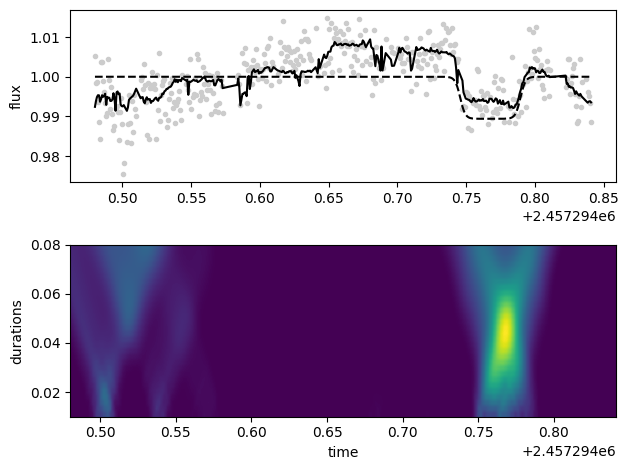

In [4]:
from nuance import core

i, duration_i = np.unravel_index(np.argmax(lls), lls.shape)
t0, D = epochs[i], durations[duration_i]

linear, astro, noise = core.separate_models(time, flux, X=X)(t0, D)


plt.subplot(211)
plt.plot(time, flux, ".", c="0.8")
plt.plot(time, linear + astro + noise, c="k", label="full model")
plt.plot(time, astro + 1.0, ls="--", c="k", label="found")
plt.ylabel("flux")

plt.subplot(212)
plt.imshow(
    lls.T,
    aspect="auto",
    origin="lower",
    extent=[time.min(), time.max(), durations.min(), durations.max()],
)
plt.ylabel("durations")
plt.xlabel("time")

plt.tight_layout()

print(f"t0: {t0}\n D: {D}")

Has we can see the transit has been properly detected.